In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import mymysql
import pandas as pd
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif',})
labelsize=16
ticksize=12
legendsize=12

simulations = [
    ('Eagle','Eagle100-1','Eagle100_1','EAGLE'),
    ('Simba','Simba100-1','Simba100_1','SIMBA'),
    ('IllustrisTNG','TNG100-1','TNG100_1','TNG100'),
    ('IllustrisTNG','TNG50-1','IllustrisTNG50_1','TNG50'),
]

from astropy.cosmology import Planck15 as cosmo
little_h = cosmo.H0.value/100
baryon_fraction = cosmo.Ob0/cosmo.Om0

Eagle100-1 Boxsize 67.77 Mpc/h, Omega_m = 0.307

TNG100-1 Boxsize 75.00 Mpc/h, Omega_m = 0.3089

TNG50-1 Boxsize 35.00 Mpc/h, Omega_m = 0.3089

Simba100-1 Boxsize 100.00 Mpc/h, Omega_m = 0.3000

In [6]:
query = [
    'SELECT',
    # identifier properties
    'm.DatabaseID, s.SnapNum, s.SubfindID, m.Camera, m.Band,',
    # Subhalos properties
    's.SubhaloMass, s.SubhaloSFR, s.GroupMass, s.Group_M_Crit200,',
    's.Group_M_Crit500, s.Group_R_Crit200, s.Group_R_Crit500,',
    's.GroupVelDisp, s.GroupVelDispMassWeighted, s.GroupVelDisp_Z,',
    's.GroupVelDispMassWeighted_Z, s.SubhaloMassType_stars,',
    's.GroupFirstSub,',
    # Morphologies properties
    'm.Sersic_mag, m.Sersic_nser, m.Sersic_re, m.Sersic_axrat,',
    'm.ProFound_R50, m.Profound_mag, m.ResidualAsymmetryNoAperture,',
    'm.AsymmetryNoAperture, m.SB1kpc, m.ReducedChiSquared',
    # Joins
    'FROM Subhalos as s',
    'JOIN Morphologies_ProFit_HSC_Sersic as m',
    'ON s.snapnum=m.snapnum and s.subfindid=m.subfindid',
    # Conditions
    'WHERE m.processflag=0 and s.snapnum=91',
    'ORDER BY m.snapnum,m.subfindid,m.camera,m.band'
]

database = 'TNG100_1'
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')


/software/projects/pawsey1149/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


Text(12, 11.5, '$M_{vir}\\times f_{\\mathrm{baryon}}$')

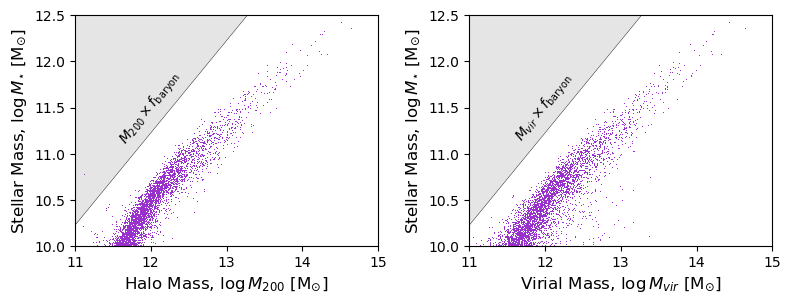

In [7]:
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
mdyn = df_cen['SubhaloMass']
A = 2
G = 4.301e-9 # Msun^-1 km^2 s^-2 Mpc 
mvir = np.log10(A/G * df_cen['GroupVelDisp']**2 * df_cen['Group_R_Crit200']/1e3)

fig, axarr = plt.subplots(1,2,figsize=(9,3), sharey=False)
fig.subplots_adjust(wspace=0.3)

xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675


ax = axarr[0]
# mstar vs m200
ax.scatter(mhalo,mstar,s=0.1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=52,
)

ax = axarr[1]
# mstar vs m200
ax.scatter(mvir,mstar,s=0.1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Virial Mass, $\log M_{vir}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{vir}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=52,
)

fig.savefig('figures/Mstar_Mhalo_Mvir_TNG100-1.jpg',dpi=256,bbox_inches='tight')

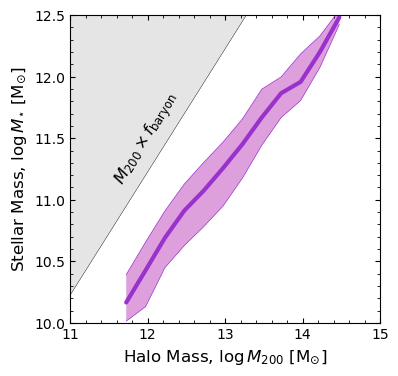

In [83]:
def mstar_mhalo(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
):
    
    # mstar vs m200
    if scatter:
        ax.scatter(
            mhalo, mstar, s=0.1, lw=0, ec=None, 
            c=scolor, marker='o'
        )
    nbins = 12
    xedges = np.linspace(11.6,14.6,nbins+1)
    widths= xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    bin_idxs = np.digitize(mhalo,xedges)-1
    med = np.zeros(nbins)
    pupper = np.zeros(nbins)
    plower = np.zeros(nbins)
    for idx in range(nbins):
        sample = mstar[bin_idxs == idx]
        med[idx] = np.nanmedian(sample)
        pupper[idx] = np.nanpercentile(sample,95)
        plower[idx] = np.nanpercentile(sample,5)

    ax.plot(xcs,med,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label)
    ax.plot(xcs,plower,ls='solid',c=lcolor,lw=0.5,solid_capstyle='round')
    ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=0.5,solid_capstyle='round')
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)


fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=59, fontsize=12,
)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

# TNG100
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

mstar_mhalo(
    ax, 'TNG100-1', mstar, mhalo, scolor='black',
    lcolor='darkorchid', fcolor='plum', fill=True,
    scatter=False,
)

fig.savefig('figures/Mstar_Mhalo_Mvir_TNG100-1.jpg',dpi=256,bbox_inches='tight')

/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


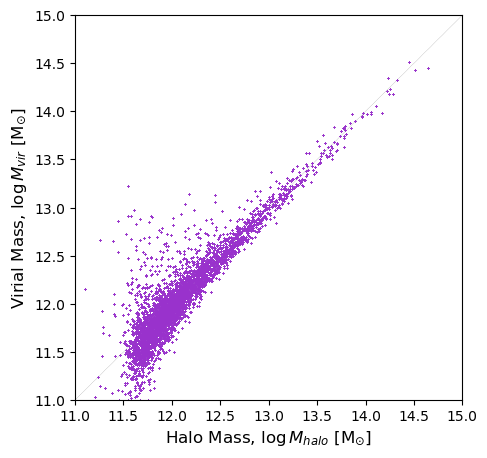

In [165]:
mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
rhalo = df_cen['Group_R_Crit200']
mdyn = df_cen['SubhaloMass']
xmin,xmax=11.,15.

A = 2
G = 4.301e-9 # Msun^-1 km^2 s^-2 Mpc 
mvir = np.log10(A/G * df_cen['GroupVelDisp_Z']**2 * df_cen['Group_R_Crit200']/1e3)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(mhalo,mvir,s=1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
ax.set_xlabel('Halo Mass, $\log M_{halo}$ [M$_{\odot}$]',fontsize=12)
ax.set_ylabel('Virial Mass, $\log M_{vir}$ [M$_{\odot}$]',fontsize=12)
ax.plot([xmin,xmax],[xmin,xmax],ls='dashed',c='black',zorder=-1,lw=0.1)

fig.savefig('figures/Mvir_Mhalo_TNG100.jpg',dpi=256,bbox_inches='tight')

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=c

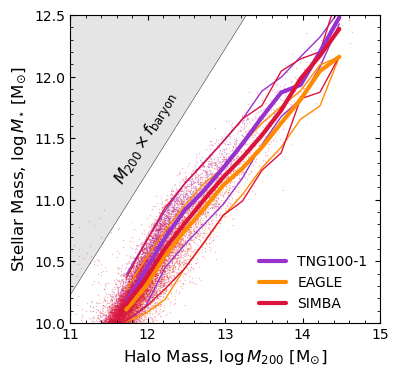

In [17]:
def mstar_mhalo(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
    limits = False,
):
    
    # mstar vs m200
    if scatter:
        ax.scatter(
            mhalo, mstar, s=1, lw=0, ec=None, 
            c=scolor, marker='o', alpha=0.3,
            zorder=-1,
        )
    nbins = 12
    xedges = np.linspace(11.6,14.6,nbins+1)
    widths= xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    bin_idxs = np.digitize(mhalo,xedges)-1
    med = np.zeros(nbins)
    pupper = np.zeros(nbins)
    plower = np.zeros(nbins)
    for idx in range(nbins):
        sample = mstar[bin_idxs == idx]
        med[idx] = np.nanmedian(sample)
        pupper[idx] = np.nanpercentile(sample,95)
        plower[idx] = np.nanpercentile(sample,5)

    ax.plot(xcs,med,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label,zorder=1)
    if limits:
        ax.plot(xcs,plower,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
        ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)

    return ax


fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=59, fontsize=12,
)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

# TNG50
database='IllustrisTNG50_1'
label='TNG50'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, 'TNG50', mstar, mhalo, scolor='mediumblue',
    lcolor='mediumblue', fcolor='royalblue', fill=False,
    scatter=True, limits=True
)

# TNG100
database='TNG100_1'
label='TNG100'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, 'TNG100', mstar, mhalo, scolor='darkorchid',
    lcolor='darkorchid', fcolor='plum', fill=False,
    scatter=True, limits=True
)

# Eagle
database='Eagle100_1'
label='EAGLE'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=27 and s.Snapnum<=27',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, label, mstar, mhalo, scolor='darkorange',
    lcolor='darkorange', fcolor='orange', fill=False,
    scatter=True, limits=True
)

# SIMBA
database='Simba100_1'
label='SIMBA'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=145 and s.Snapnum<=145',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, label, mstar, mhalo, scolor='crimson',
    lcolor='crimson', fcolor='orangered', fill=False,
    scatter=True, limits =True
)

ax.legend(loc=4,edgecolor='None')
fig.savefig('figures/Mvir_Mhalo.png', dpi=256, bbox_inches='tight')

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


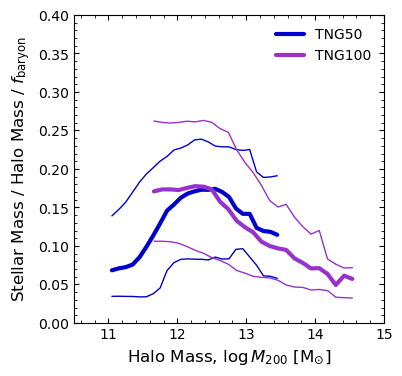

In [68]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 10.5,15
ymin,ymax = 0,0.3

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass / Halo Mass / $f_{\mathrm{baryon}}$',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

def shmr(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
    limits = False, kernel_size=0.2, nbins=100,
):

    baryon_fraction = 0.1675
    shmr = 10**(mstar-mhalo)/baryon_fraction
    if scatter:
        ax.scatter(
            mhalo, shmr, s=1, lw=0, ec=None, 
            c=scolor, marker='o', alpha=0.3, zorder=-1,
        )

    if label=='TNG50':
        xmin,xmax = 11,13.5
    else:
        xmin,xmax = 11.6,14.6
    
    xedges = np.linspace(xmin,xmax,nbins+1)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    meds = np.zeros(nbins)
    plower = np.zeros(nbins)
    pupper = np.zeros(nbins)
    for j,xc in enumerate(xcs):
        mask = (mhalo>=xc-kernel_size) * (mhalo<(xc+kernel_size))
        meds[j] = np.nanmedian(shmr[mask])
        pupper[j] = np.nanpercentile(shmr[mask],95)
        plower[j] = np.nanpercentile(shmr[mask],5)

    ax.plot(xcs,meds,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label,zorder=1)
    if limits:
        ax.plot(xcs,plower,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
        ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)

    
    return ax

# TNG50
database='IllustrisTNG50_1'
label='TNG50'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]
mstar = df_cen['SubhaloMassType_stars']+np.log10(1/1.5)
mhalo = df_cen['Group_M_Crit200']
ax = shmr(
    ax, label, mstar, mhalo, scolor='mediumblue',
    lcolor='mediumblue', fcolor='royalblue', fill=False,
    scatter=False, limits =True, kernel_size=0.4, nbins=25
)


# TNG100
database='TNG100_1'
label='TNG100'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]
mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
ax = shmr(
    ax, label, mstar, mhalo, scolor='darkorchid',
    lcolor='darkorchid', fcolor='plum', fill=False,
    scatter=False, limits =True, kernel_size=0.4, nbins=25
)

# # EAGLE
# database='Eagle100_1'
# label='EAGLE'
# query = [
#     'SELECT',
#     's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
#     's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
#     'FROM Subhalos as s',
#     'WHERE s.SnapNum>=27 and s.Snapnum<=27',
#     'ORDER BY s.snapnum,s.subfindid', 
# ]
# query = ' '.join(query)
# df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
# df_cen = df.loc[df['GroupFirstSub']==1]
# df_sat = df.loc[df['GroupFirstSub']==0]
# mstar = df_cen['SubhaloMassType_stars']
# mhalo = df_cen['Group_M_Crit200']
# ax = shmr(
#     ax, label, mstar, mhalo, scolor='darkorange',
#     lcolor='darkorange', fcolor='orange', fill=False,
#     scatter=False, limits=True, kernel_size=0.4, nbins=25
# )

# # SIMBA
# database='Simba100_1'
# label='SIMBA'
# query = [
#     'SELECT',
#     's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
#     's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
#     'FROM Subhalos as s',
#     'WHERE s.SnapNum>=145 and s.Snapnum<=145',
#     'ORDER BY s.snapnum,s.subfindid',
# ]
# query = ' '.join(query)
# df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
# df_cen = df.loc[df['GroupFirstSub']==1]
# df_sat = df.loc[df['GroupFirstSub']==0]
# mstar = df_cen['SubhaloMassType_stars']
# mhalo = df_cen['Group_M_Crit200']
# ax = shmr(
#     ax, label, mstar, mhalo, scolor='crimson',
#     lcolor='crimson', fcolor='orangered', fill=False,
#     scatter=False, limits =True, kernel_size=0.4, nbins=25,
# )

ax.legend(loc=1,edgecolor='None')
fig.savefig('figures/SHMR.png', dpi=256, bbox_inches='tight')

### Add stellar mass/flux resolution corrections to TNG50-1 catalogue



In [46]:
import pandas as pd
import numpy as np

table_filename = 'catalogues/HaloFlow_TNG50-1_Uncorrected.csv'
df = pd.read_csv(table_filename)
m200 = df['Group_M_Crit200']
mstar = df['SubhaloMassType_stars']

corr_filename = 'catalogues/StellarMassResCorrection_TNG50-1.csv'
df_corr = pd.read_csv(corr_filename)

df['StellarMassCorrection'] = np.interp(
    m200, xp=df_corr['Group_M_Crit200'], 
    fp=df_corr['StellarMassResCorrection']
)

df['MagnitudeCorrection'] = -2.5*np.log10(10**df['StellarMassCorrection'])

df.to_csv('catalogues/HaloFlow_TNG50-1.csv',index=False)


/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1236942/1524161245.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1236942/1524161245.py:10: RuntimeWarning: Mean of empty slice
  avg[idx] = np.nanmean(y[mask])
/tmp/ipykernel_1236942/1524161245.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-

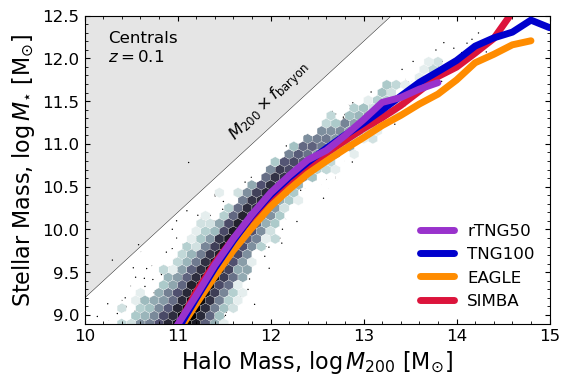

In [19]:
def rolling_average_2d(
    x, y, xmin = 8, xmax = 15, dx = 0.01, kernel_size = 0.1
):
    xcs = np.arange(xmin,xmax+dx,dx)
    # compute rolling average
    avg = np.zeros(len(xcs))*np.nan
    var = np.zeros(len(xcs))*np.nan
    for idx, xc in enumerate(xcs):
        mask = (x>=(xc-kernel_size)) * (x<(xc+kernel_size))
        avg[idx] = np.nanmean(y[mask])
        var[idx] = np.nanvar(y[mask],ddof=1)
    return avg, var, xcs


fig, ax = plt.subplots(1,1,figsize=(6,4))
xmin,xmax = 10, 15
ymin,ymax = 8.9, 12.5
kernel_size = 0.4
dx = 0.2
baryon_fraction = 0.0486 / 0.308
little_h = 0.6774

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=labelsize)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=labelsize)

# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=45, fontsize=12,
)
ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=ticksize)
ax.minorticks_on()


# TNG50
filename = 'catalogues/HaloFlow_TNG50-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)

filename = 'catalogues/StellarMassResCorrection_TNG50-1.csv'
df_corr = pd.read_csv(filename)
delta_mstar = np.interp(
    df['Mhalo'], xp=df_corr['Group_M_Crit200'], fp=df_corr['StellarMassResCorrection']
)
df['Mstar'] += delta_mstar

df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=13.8, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.log10(avg), c='darkorchid', lw=5, solid_capstyle='round',label='rTNG50',zorder=4)


# TNG100
filename = 'catalogues/HaloFlow_TNG100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)

df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='black',edgecolor='None',zorder=-2)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.log10(avg), c='mediumblue', lw=5, solid_capstyle='round',label='TNG100',zorder=3)

cmap = cm.bone_r.copy()
ax.hexbin(
    df_cen['Mhalo'], df_cen['Mstar'], extent=(xmin,xmax,ymin,ymax), zorder=-1, cmap=cmap,
    gridsize=(50,20), mincnt=2, edgecolor='white', bins='log', vmin=2, linewidth=0.2,
)


# Eagle
filename = 'catalogues/HaloFlow_Eagle100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)

df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==27)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==27)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='black',edgecolor='None',zorder=-1)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.log10(avg), c='darkorange', lw=5, solid_capstyle='round',label='EAGLE',zorder=2)

# Simba
filename = 'catalogues/HaloFlow_Simba100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)

df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==145)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==145)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='black',edgecolor='None',zorder=-1)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.log10(avg), c='crimson', lw=5, solid_capstyle='round',label='SIMBA',zorder=1)

ax.text(0.05,0.95,'Centrals\n$z=0.1$',ha='left',va='top',transform=ax.transAxes, fontsize=legendsize)


ax.legend(loc=4,edgecolor='None',framealpha=0.3, fontsize=legendsize)


# fig.savefig('figures/SHMR.png', dpi=256, bbox_inches='tight')


/tmp/ipykernel_1472589/3222935677.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/tmp/ipykernel_1472589/3222935677.py:12: RuntimeWarning: Mean of empty slice
  avg[idx] = np.nanmean(y[mask])


[0.00321969 0.00592463 0.01208464 0.02133095 0.0342408  0.05157494
 0.07242953 0.10143388 0.13371925 0.1693475  0.18789636 0.19123354
 0.18616935 0.17042508 0.15283868 0.13254794 0.10880901 0.10651856
 0.08056088 0.08231488 0.08889385 0.08389424 0.11064833        nan
        nan]


/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1472589/3222935677.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


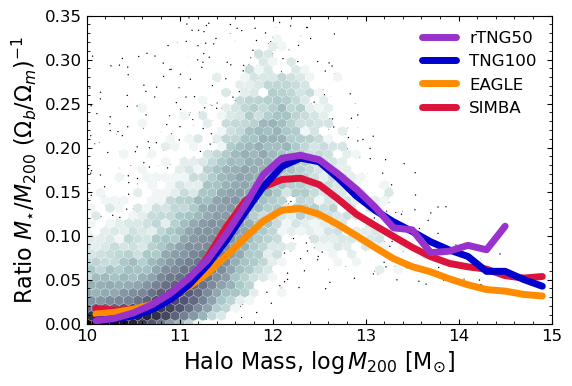

In [34]:
def rolling_average_2d(
    x, y, xmin = 8, xmax = 15, dx = 0.01, kernel_size = 0.1
):
    xedges = np.arange(xmin,xmax+dx,dx)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2
    # compute rolling average
    avg = np.zeros(len(xcs))*np.nan
    var = np.zeros(len(xcs))*np.nan
    for idx, xc in enumerate(xcs):
        mask = (x>=(xc-kernel_size)) * (x<(xc+kernel_size))
        avg[idx] = np.nanmean(y[mask])
        var[idx] = np.nanvar(y[mask],ddof=1)
    return avg, var, xcs


fig, ax = plt.subplots(1,1,figsize=(6,4))
xmin,xmax = 10, 15
ymin,ymax = 0.0, 0.35
dx = 0.2
kernel_size = 0.4
baryon_fraction = 0.0485/0.308
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Ratio $M_{\star}/M_{200}$ $(\Omega_b / \Omega_m)^{-1}$', fontsize=labelsize)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=labelsize)
ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=ticksize)
ax.minorticks_on()


# TNG50
filename = 'catalogues/HaloFlow_TNG50-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
filename = 'catalogues/StellarMassResCorrection_TNG50-1.csv'
df_corr = pd.read_csv(filename)
delta_mstar = np.interp(
    df['Mhalo'], xp=df_corr['Group_M_Crit200'], fp=df_corr['StellarMassResCorrection']
)
df['Mstar'] += delta_mstar
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
print(avg)
ax.plot(xcs, avg, c='darkorchid', lw=5, solid_capstyle='round',label='rTNG50',zorder=4)

# TNG100
filename = 'catalogues/HaloFlow_TNG100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

ax.scatter(
    df_cen['Mhalo'],10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction,
    s=1,marker='o',c='black',edgecolor='None',zorder=-2
)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, avg, c='mediumblue', lw=5, solid_capstyle='round',label='TNG100',zorder=3)

cmap = cm.bone_r.copy()
ax.hexbin(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    extent=(xmin,xmax,ymin,ymax), zorder=-1, cmap=cmap,
    gridsize=(50,20), mincnt=2, edgecolor='white', bins='log',
    vmin=2, linewidth=0.2,
)

# Eagle
filename = 'catalogues/HaloFlow_Eagle100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==27)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==27)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, avg, c='darkorange', lw=5, solid_capstyle='round',label='EAGLE',zorder=2)

# Simba
filename = 'catalogues/HaloFlow_Simba100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==145)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==145)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, avg, c='crimson', lw=5, solid_capstyle='round',label='SIMBA',zorder=1)

ax.legend(loc=1,edgecolor='None',framealpha=0.3, fontsize=legendsize)
fig.savefig('figures/SHMR.png', dpi=256, bbox_inches='tight')


/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1472589/3550843575.py:12: RuntimeWarning: Mean of empty slice
  avg[idx] = np.nanmean(y[mask])
/tmp/ipykernel_1472589/3550843575.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1472589/3550843575.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/tmp/ipykernel_1472589/3550843575.py:12: RuntimeWarning: Mean of empty sli

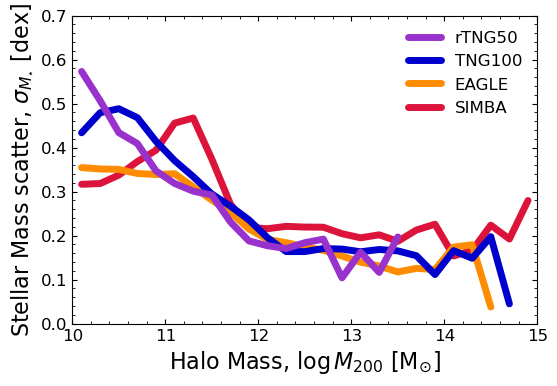

In [104]:
def rolling_average_2d(
    x, y, xmin = 8, xmax = 15, dx = 0.01, kernel_size = 0.1
):
    xedges = np.arange(xmin,xmax+dx,dx)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2
    # compute rolling average
    avg = np.zeros(len(xcs))*np.nan
    var = np.zeros(len(xcs))*np.nan
    for idx, xc in enumerate(xcs):
        mask = (x>=(xc-kernel_size)) * (x<(xc+kernel_size))
        avg[idx] = np.nanmean(y[mask])
        var[idx] = np.nanvar(y[mask],ddof=1)
    return avg, var, xcs


fig, ax = plt.subplots(1,1,figsize=(6,4))
xmin,xmax = 10, 15
ymin,ymax = 0.0, 0.7
dx = 0.2
kernel_size = 0.2
baryon_fraction = 0.0485/0.308
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass scatter, $\sigma_{M_{\star}}$ [dex]', fontsize=labelsize)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=labelsize)
ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=ticksize)
ax.minorticks_on()


# TNG50
filename = 'catalogues/HaloFlow_TNG50-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
filename = 'catalogues/StellarMassResCorrection_TNG50-1.csv'
df_corr = pd.read_csv(filename)
delta_mstar = np.interp(
    df['Mhalo'], xp=df_corr['Group_M_Crit200'], fp=df_corr['StellarMassResCorrection']
)
df['Mstar'] += delta_mstar
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], df_cen['Mstar'], 
    xmin=10, xmax=13.6, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.sqrt(var), c='darkorchid', lw=5, solid_capstyle='round',label='rTNG50',zorder=4)

# TNG100
filename = 'catalogues/HaloFlow_TNG100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], df_cen['Mstar'], 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.sqrt(var), c='mediumblue', lw=5, solid_capstyle='round',label='TNG100',zorder=3)


# Eagle
filename = 'catalogues/HaloFlow_Eagle100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==27)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==27)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], df_cen['Mstar'], 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.sqrt(var), c='darkorange', lw=5, solid_capstyle='round',label='EAGLE',zorder=2)

# Simba
filename = 'catalogues/HaloFlow_Simba100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==145)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==145)]

# ax.scatter(df_cen['Mhalo'],df_cen['Mstar'],s=1,marker='o',c='darkorchid',edgecolor='None')
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], df_cen['Mstar'], 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
ax.plot(xcs, np.sqrt(var), c='crimson', lw=5, solid_capstyle='round',label='SIMBA',zorder=1)

ax.legend(loc=1,edgecolor='None',framealpha=0.3, fontsize=legendsize)
fig.savefig('figures/SHMR_scatter.png', dpi=256, bbox_inches='tight')


/tmp/ipykernel_1472589/3490086406.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/tmp/ipykernel_1472589/3490086406.py:12: RuntimeWarning: Mean of empty slice
  avg[idx] = np.nanmean(y[mask])
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1472589/3490086406.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-

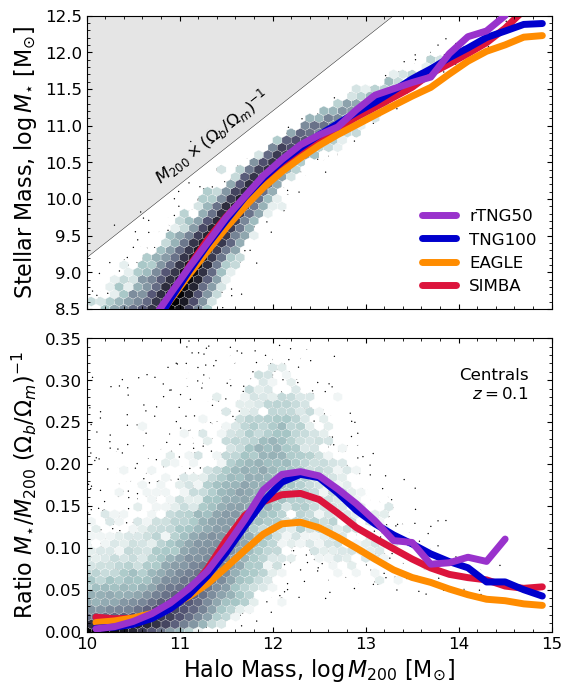

In [105]:
def rolling_average_2d(
    x, y, xmin = 8, xmax = 15, dx = 0.01, kernel_size = 0.1
):
    xedges = np.arange(xmin,xmax+dx,dx)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2
    # compute rolling average
    avg = np.zeros(len(xcs))*np.nan
    var = np.zeros(len(xcs))*np.nan
    for idx, xc in enumerate(xcs):
        mask = (x>=(xc-kernel_size)) * (x<(xc+kernel_size))
        avg[idx] = np.nanmean(y[mask])
        var[idx] = np.nanvar(y[mask],ddof=1)
    return avg, var, xcs



fig, axarr = plt.subplots(2,1,figsize=(6,8), sharex=True)
fig.subplots_adjust(hspace=0.1)
xmin,xmax = 10, 15
ymin,ymax = 8.5, 12.5
ymin1,ymax1 = 0.0, 0.35
kernel_size = 0.4
dx = 0.2
baryon_fraction = 0.0486 / 0.308
little_h = 0.6774

for ax in axarr.flat:
    ax.set_xlim(xmin,xmax)
    ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=ticksize)
    ax.minorticks_on()

axarr[1].set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=labelsize)
axarr[0].set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=labelsize)
axarr[1].set_ylabel('Ratio $M_{\star}/M_{200}$ $(\Omega_b / \Omega_m)^{-1}$', fontsize=labelsize)
axarr[0].set_ylim(ymin,ymax)
axarr[1].set_ylim(ymin1,ymax1)
axarr[0].set_xlim(xmin,xmax)

# cosmic baryon fraction
axarr[0].plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
axarr[0].fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
axarr[0].text(
    11.35,10.85,'$M_{200}\\times (\Omega_b / \Omega_m)^{-1}$',
    transform=axarr[0].transData, ha='center',va='center', rotation=38, fontsize=12,
)

# TNG50
filename = 'catalogues/HaloFlow_TNG50-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
filename = 'catalogues/StellarMassResCorrection_TNG50-1.csv'
df_corr = pd.read_csv(filename)
delta_mstar = np.interp(
    df['Mhalo'], xp=df_corr['Group_M_Crit200'], fp=df_corr['StellarMassResCorrection']
)
df['Mstar'] += delta_mstar
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[0].plot(xcs, np.log10(avg), c='darkorchid', lw=5, solid_capstyle='round',label='rTNG50',zorder=4)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[1].plot(xcs, avg, c='darkorchid', lw=5, solid_capstyle='round',label='rTNG50',zorder=4)

# TNG100
filename = 'catalogues/HaloFlow_TNG100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)

df_cen = df.loc[(df['GroupFirstSub']==1) & (df['SnapNum']==91)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91)]

axarr[0].scatter(
    df_cen['Mhalo'], df_cen['Mstar'], s=1, marker='o',
    c='black',edgecolor='None',zorder=-2
)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[0].plot(xcs, np.log10(avg), c='mediumblue', lw=5, solid_capstyle='round',label='TNG100',zorder=3)

cmap = cm.bone_r.copy()
axarr[0].hexbin(
    df_cen['Mhalo'], df_cen['Mstar'], extent=(xmin,xmax,ymin,ymax), zorder=-1, cmap=cmap,
    gridsize=(50,20), mincnt=2, edgecolor='white', bins='log', vmin=2, linewidth=0.2,
)

axarr[1].scatter(
    df_cen['Mhalo'],10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction,
    s=1,marker='o',c='black',edgecolor='None',zorder=-2
)

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)

axarr[1].plot(xcs, avg, c='mediumblue', lw=5, solid_capstyle='round',label='TNG100',zorder=3)
axarr[1].hexbin(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    extent=(xmin,xmax,ymin1,ymax1), zorder=-1, cmap=cmap,
    gridsize=(50,20), mincnt=2, edgecolor='white', bins='log',
    vmin=2, linewidth=0.2,
)

# Eagle
filename = 'catalogues/HaloFlow_Eagle100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==27)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==27)]

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[0].plot(xcs, np.log10(avg), c='darkorange', lw=5, solid_capstyle='round',label='EAGLE',zorder=2)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[1].plot(xcs, avg, c='darkorange', lw=5, solid_capstyle='round',label='EAGLE',zorder=2)

# TNG50
filename = 'catalogues/HaloFlow_Simba100-1_Subhalos.csv'
df = pd.read_csv(filename)
df['Mstar'] = np.log10(df['SubhaloMassType_stars']*1e10/little_h)
df['Mhalo'] = np.log10(df['Group_M_Crit200']*1e10/little_h)
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==145)]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==145)]

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[0].plot(xcs, np.log10(avg), c='crimson', lw=5, solid_capstyle='round',label='SIMBA',zorder=1)
avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**(df_cen['Mstar']-df_cen['Mhalo'])/baryon_fraction, 
    xmin=10, xmax=15, dx=dx, kernel_size=kernel_size
)
axarr[1].plot(xcs, avg, c='crimson', lw=5, solid_capstyle='round',label='SIMBA',zorder=1)

axarr[1].text(
    0.95,0.9,'Centrals\n$z=0.1$',ha='right', va='top',
    transform=axarr[1].transAxes, fontsize=legendsize
)

axarr[0].legend(loc=4,edgecolor='None',framealpha=0.3, fontsize=legendsize)


fig.savefig('figures/SHMR.png', dpi=256, bbox_inches='tight')


For each simulation, detrend the SHMR and show correlation with physical parameters.

/tmp/ipykernel_831713/3445738043.py:12: RuntimeWarning: Mean of empty slice
  avg[idx] = np.nanmean(y[mask])
/tmp/ipykernel_831713/3445738043.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var[idx] = np.nanvar(y[mask],ddof=1)
/tmp/ipykernel_831713/3445738043.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cen['DeltaSHMR'] = df_cen['Mstar'] - shmr


count    8979.000000
mean        7.697808
std         0.567490
min         4.564624
25%         7.349101
50%         7.639004
75%         7.953822
max        10.872831
dtype: float64
4         5.984547
13        7.396509
19        6.323179
24        6.257956
27        3.002548
           ...    
72112     7.701837
72121     4.982457
72127    10.011732
72143     8.805028
72144     3.911701
Name: ProFound_R50, Length: 8996, dtype: float64


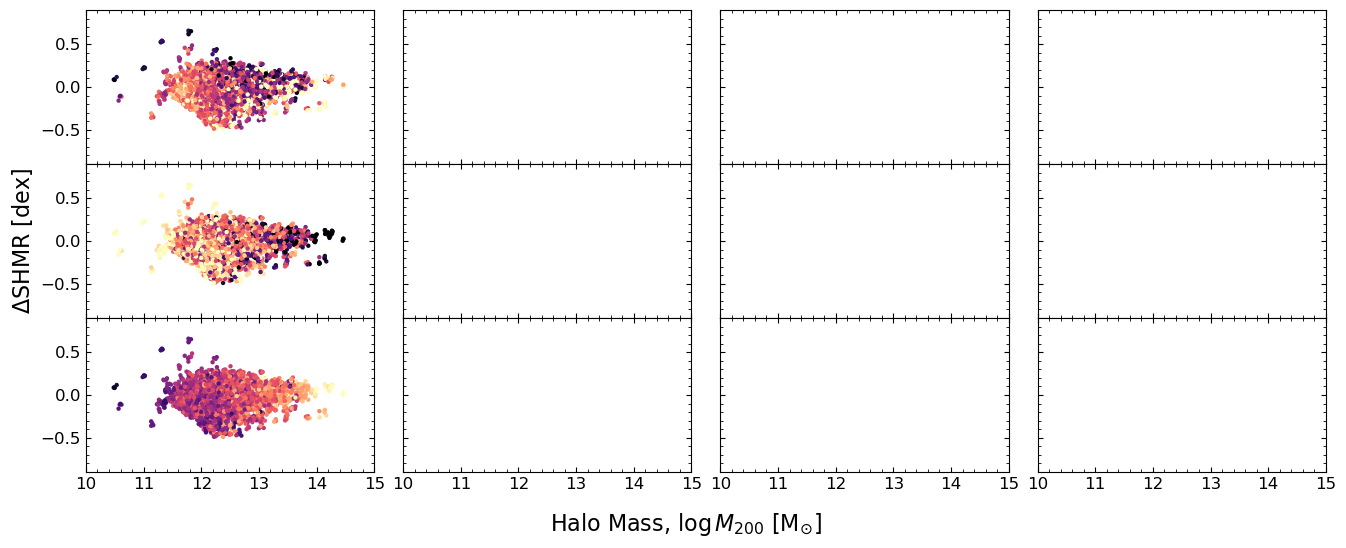

In [86]:
def rolling_average_2d(
    x, y, xmin = 8, xmax = 15, dx = 0.01, kernel_size = 0.1
):
    xedges = np.arange(xmin,xmax+dx,dx)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2
    # compute rolling average
    avg = np.zeros(len(xcs))*np.nan
    var = np.zeros(len(xcs))*np.nan
    for idx, xc in enumerate(xcs):
        mask = (x>=(xc-kernel_size)) * (x<(xc+kernel_size))
        avg[idx] = np.nanmean(y[mask])
        var[idx] = np.nanvar(y[mask],ddof=1)
    return avg, var, xcs

nrows, ncols = 3, 4
fig, axarr = plt.subplots(nrows,ncols,figsize=(ncols*4,nrows*2), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
xmin,xmax = 10, 15
ymin,ymax = -0.9, 0.9
kernel_size = 0.2
dx = 0.1


cmap = cm.magma.copy()
np.random.seed(666)

for ax in axarr.flat:
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(which='both', direction='in', top=True, right=True, labelsize=ticksize)
    ax.minorticks_on()

fig.text(0.5, 0.00, 
    'Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=labelsize, ha='center', va='bottom'
)
axarr[1,0].set_ylabel(
    '$\Delta$SHMR [dex]',fontsize=labelsize
)

# Eagle
filename = 'catalogues/HaloFlow_Eagle100-1.csv'
df = pd.read_csv(filename)
df = df.sample(frac=1).reset_index(drop=True)
df['Mstar'] = df['SubhaloMassType_stars']
df['Mhalo'] = df['Group_M_Crit200']
df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==27) & (df['Band']=='i')] # & (df['Camera']=='v0')]
df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==27) & (df['Band']=='i')] # & (df['Camera']=='v0')]

kpc_per_pixel = cosmo.kpc_proper_per_arcmin(df_cen['Redshift']).value/60 * 0.168

avg, var, xcs = rolling_average_2d(
    df_cen['Mhalo'], 10**df_cen['Mstar'], xmin=8, xmax=15, dx=dx, kernel_size=kernel_size
)
shmr = np.interp(
    df_cen['Mhalo'], xp=xcs, fp=np.log10(avg)
)
df_cen['DeltaSHMR'] = df_cen['Mstar'] - shmr

jitter = 0.025
v1_mask = (df_cen['Camera']=='v1')
df_cen.loc[v1_mask, 'Mhalo'] += np.random.normal(loc=0., scale=jitter, size=sum(v1_mask))
df_cen.loc[v1_mask, 'DeltaSHMR'] += np.random.normal(loc=0., scale=jitter, size=sum(v1_mask))
v2_mask = (df_cen['Camera']=='v2')
df_cen.loc[v2_mask, 'Mhalo'] += np.random.normal(loc=0., scale=jitter, size=sum(v2_mask))
df_cen.loc[v2_mask, 'DeltaSHMR'] += np.random.normal(loc=0., scale=jitter, size=sum(v2_mask))
v3_mask = (df_cen['Camera']=='v3')
df_cen.loc[v3_mask, 'Mhalo'] += np.random.normal(loc=0., scale=jitter, size=sum(v3_mask))
df_cen.loc[v3_mask, 'DeltaSHMR'] += np.random.normal(loc=0., scale=jitter, size=sum(v3_mask))

axarr[0,0].scatter(
    df_cen['Mhalo'], df_cen['DeltaSHMR'], c=df_cen['SB1kpc'],
    s=10, marker='o', edgecolor='None', zorder=0, vmin=18, vmax=22, cmap=cmap
)
# -0.693*self.m20 + 4.95*self.gini - 3.96
axarr[1,0].scatter(
    df_cen['Mhalo'], df_cen['DeltaSHMR'], c=-0.693*df_cen['M20'] + 4.95*df_cen['Gini'] + 3.96,
    s=10, marker='o', edgecolor='None', zorder=0, vmin=6, vmax= 8, cmap=cmap,
)

print((df_cen['M20'] + 4.95*df_cen['Gini'] + 3.96).describe())

axarr[2,0].scatter(
    df_cen['Mhalo'], df_cen['DeltaSHMR'], c=np.log10(df_cen['ProFound_R50']*kpc_per_pixel),
    s=10, marker='o', edgecolor='None', zorder=0, vmin=0, vmax=1.5, cmap=cmap
)

print(df_cen['ProFound_R50']*kpc_per_pixel)

# # TNG100
# filename = 'catalogues/HaloFlow_TNG100-1.csv'
# df = pd.read_csv(filename)
# df['Mstar'] = df['SubhaloMassType_stars']
# df['Mhalo'] = df['Group_M_Crit200']
# df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91) & (df['Band']=='i') & (df['Camera']=='v0')]
# df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91) & (df['Band']=='i') & (df['Camera']=='v0')]

# axarr[0,2].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['Sersic_nser'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.5, vmax=2.5, cmap=cmap
# )

# axarr[1,2].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['ProFound_con'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.2, vmax=0.6, cmap=cmap
# )

# axarr[2,2].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['Sersic_axrat'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.2, vmax=0.8, cmap=cmap
# )


# # TNG50
# filename = 'catalogues/HaloFlow_TNG50-1.csv'
# df = pd.read_csv(filename)
# df['Mstar'] = df['SubhaloMassType_stars']
# df['Mhalo'] = df['Group_M_Crit200']
# df_cen = df.loc[(df['GroupFirstSub']>0) & (df['SnapNum']==91) & (df['Band']=='i') & (df['Camera']=='v0')]
# df_sat = df.loc[(df['GroupFirstSub']==0) & (df['SnapNum']==91) & (df['Band']=='i') & (df['Camera']=='v0')]

# axarr[0,3].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['Sersic_nser'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.5, vmax=2.5, cmap=cmap
# )

# axarr[1,3].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['Concentra'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.2, vmax=0.6, cmap=cmap
# )

# axarr[2,3].scatter(
#     df_cen['Mhalo'], df_cen['Mstar'], c=df_cen['Sersic_axrat'],
#     s=10, marker='o', edgecolor='None', zorder=0, vmin=0.2, vmax=0.8, cmap=cmap
# )




fig.savefig('figures/DeltaSHMR.png', dpi=256, bbox_inches='tight')


In [108]:
df_cen[['Concentration_Circular','Concentration_Elliptical','SB1kpc','Sersic_axrat', 'ProFound_con']].describe()

,Concentration_Circular,Concentration_Elliptical,SB1kpc,Sersic_axrat,ProFound_con
count,9055.000000,9055.000000,9055.000000,9066.000000,9066.000000
mean,2.833193,2.758520,20.743307,0.795557,0.403885
std,0.365079,0.376876,0.891891,0.173692,0.044453
min,0.657516,0.755329,16.672600,0.065437,0.211511
25%,2.668955,2.578210,20.190000,0.713578,0.377065
50%,2.861090,2.804610,20.702700,0.836131,0.405895
75%,3.039630,2.987040,21.185950,0.915821,0.430226
max,4.659840,4.448590,26.398300,1.000000,0.665279


Make 2D plots of Mstar vs Mhalo 

In [95]:
for col in df_cen.columns:
    print(col)

DatabaseID
SnapNum
SubfindID
SubhaloMassType_stars
SubhaloMassType_gas
SubhaloMassType_dm
SubhaloMassInRadType_stars
SubhaloMassInRadType_gas
SubhaloMassInRadType_dm
SubhaloHalfMassRadType_stars
SubhaloHalfmassRadType_gas
SubhaloHalfmassRadType_dm
SubhaloBHMass
SubhaloBHMdot
SubhaloMass
SubhaloSFR
SubhaloSFRinHalfRad
SubhaloSFRinRad
SubhaloVelDisp
SubhaloVmax
SubhaloVmaxRad
SubhaloGrNr
GroupFirstSub
GroupNsubs
GroupMass
GroupMassType_stars
GroupMassType_gas
GroupMassType_dm
Group_M_Crit200
Group_M_Crit500
Group_R_Crit200
Group_R_Crit500
GroupVelDisp
GroupVelDisp_Z
GroupVelDispMassWeighted
GroupVelDispMassWeighted_Z
SubhaloPosInGroup_X
SubhaloPosInGroup_Y
SubhaloPosInGroup_Z
SubhaloVelInGroup_X
SubhaloVelInGroup_Y
SubhaloVelInGroup_Z
GroupCM_X
GroupCM_Y
GroupCM_Z
GroupPos_X
GroupPos_Y
GroupPos_Z
GroupVel_X
GroupVel_Y
GroupVel_Z
Redshift
Camera
Band
ProcessFlag
ApparentMagnitude
RightAscension
Declination
Sersic_xcen
Sersic_ycen
Sersic_mag
Sersic_re
Sersic_nser
Sersic_axrat
Sersic_ang
Se

(0.0, 2.0)

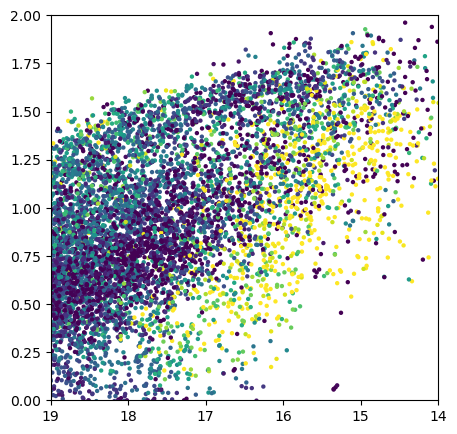

In [106]:
fig,ax = plt.subplots(figsize=(5,5))

filename = 'catalogues/HaloFlow_TNG50-1.csv'
df = pd.read_csv(filename)
df['Mstar'] = df['SubhaloMassType_stars']
df['Mhalo'] = df['Group_M_Crit200']
df_cen = df.loc[(df['SnapNum']==91) & (df['Band']=='i')] # & (df['Camera']=='v0')]


kpc_per_pixel = cosmo.kpc_proper_per_arcmin(df_cen['Redshift']).value/60 * 0.168
ax.scatter(df_cen['Sersic_mag'],np.log10(df_cen['Sersic_re']*kpc_per_pixel),s=10, ec='None',c=df_cen['Concentration_Circular'],vmin=2.5,vmax=4)

ax.set_xlim(19,14)
ax.set_ylim(0,2)

In [4]:
import pandas as pd
import mymysql

database = 'TNG100_1'
cnf_path = '~/.mysql/ningaloo.cnf'

snapmin=91
snapmax=91
logmstar_min = 10
logmstar_max = 10.5

query = [
    'SELECT',
    # identifier properties
    'm.DatabaseID, s.SnapNum, s.SubfindID, m.Camera, m.Band',
    # Subhalos properties
    # 's.SubhaloMass, s.SubhaloSFR, s.GroupMass, s.Group_M_Crit200,',
    # 's.Group_M_Crit500, s.Group_R_Crit200, s.Group_R_Crit500,',
    # 's.GroupVelDisp, s.GroupVelDispMassWeighted, s.GroupVelDisp_Z,',
    # 's.GroupVelDispMassWeighted_Z, s.SubhaloMassType_stars,',
    # 's.GroupFirstSub,',
    # Morphologies properties
    # 'm.Sersic_mag, m.Sersic_nser, m.Sersic_re, m.Sersic_axrat,',
    # 'm.ProFound_R50, m.Profound_mag, m.ResidualAsymmetryNoAperture,',
    # 'm.AsymmetryNoAperture, m.SB1kpc, m.ReducedChiSquared',
    # Joins
    'FROM Subhalos as s',
    'JOIN Morphologies_ProFit_HSC_Sersic as m',
    'ON s.snapnum=m.snapnum and s.subfindid=m.subfindid',
    # Conditions
    f'WHERE m.processflag=0 and s.snapnum>={snapmin} and s.snapnum<={snapmax}',
    'ORDER BY m.snapnum,m.subfindid,m.camera,m.band'
]

query = ' '.join(query)
query = 'select count(*) from Morphologies_ProFit_HSC_Sersic'

df = mymysql.query_df(query, database=database, cnf_path=cnf_path)

/software/projects/pawsey1149/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


In [4]:
df

,SnapNum,SubfindID
0,91,13
1,91,15
2,91,17
3,91,18
4,91,20
...,...,...
497,91,621733
498,91,627225
499,91,629512
500,91,665179
